In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import altair as alt
from altair import datum
from tqdm.auto import tqdm, trange

from src.model import tscv

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn, alt]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.0
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2
  altair: 4.1.0


We saw that our scores weren't as good as they could be, and we were a lot worse than the benchmark model. We also saw that the benchmark model does well because it simply sets all unseen values to zero and since the dataset contains a lot more fake examples it does pretty well.

First let's see the ratio of unseen examples on the test set.

In [3]:
train_sales_by_month = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'sales-train-by-month.parquet'))
test_set = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'test-set-base.parquet'))

In [6]:
last_month_sales = train_sales_by_month[train_sales_by_month['date_block_num'] == 33]
tmp_df = test_set.merge(last_month_sales, on=['item_id', 'shop_id'], how='left')['item_cnt']
tmp_df.isna().sum() / tmp_df.size

0.8661064425770308

A huge number of unseen examples here. Let's see how the ratio between one month and the other evolves on the train set now.

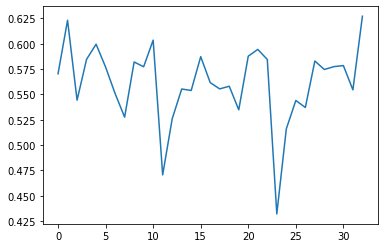

In [9]:
ratios = []
for i in range(1, 34):
    last_month_sales = train_sales_by_month[train_sales_by_month['date_block_num'] == i - 1]
    cur_month_sales = train_sales_by_month[train_sales_by_month['date_block_num'] == i]
    tmp_df = cur_month_sales.merge(last_month_sales, on=['item_id', 'shop_id'], how='left')['item_cnt_y']
    ratios.append(tmp_df.isna().sum() / tmp_df.size)

plt.plot(ratios)

Varies between 62% and 42%, which is pretty far off. Let's also check what would our "CV" score be if we used the benchmark model.

In [13]:
def predict(df, month):
    df_preds = df.copy()
    df_preds['date_block_num'] = df_preds['date_block_num'] + 1
    return df.loc[df['date_block_num'] == month, ['item_id', 'shop_id', 'date_block_num']].merge(df_preds, on=['item_id', 'shop_id', 'date_block_num'], how='left', sort=False).fillna(0)['item_cnt'].values

-2.6461388671748542

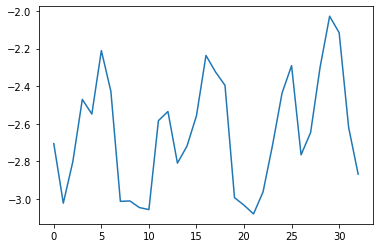

In [14]:
from sklearn.metrics import mean_squared_error

test_scores = []
for i in range(1, 34):
    y_pred = predict(train_sales_by_month, i)
    y_true = train_sales_by_month.loc[train_sales_by_month['date_block_num'] == i, 'item_cnt'].values
    test_scores.append(-mean_squared_error(y_true, y_pred, squared=False))
    
plt.plot(test_scores)
np.mean(test_scores)

A lot worse than what we get on the public LB. But we can correct this RMSE score by using the ratio difference we found before.